# Understanding Observer Orientation Relative to a Simulated Volume with `astropy.coordinates`

- https://docs.sunpy.org/en/stable/generated/gallery/showcase/los_simulation_box_intersection.html

This example demonstrates how to use the `astropy.coordinates` framework, combined with the solar
coordinate frameworks provided by ``sunpy``, to find the intersection of a set of lines of sight
defined by an observer position with a simulated volume represented by a Cartesian box.

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy.sun.constants
from sunpy.coordinates import Heliocentric, Helioprojective

First, we need to define the orientation of our box and the corresponding coordinate frame.
We do this by specifying a coordinate in the Heliographic Stonyhurst frame (HGS) and then
using that coordinate to define the coordinate frame of the simulation box in a
Heliocentric Cartesian (HCC) frame. For more information on all of these frames, see
[Thompson (2006)](https://ui.adsabs.harvard.edu/abs/2006A%26A...449..791T/abstract).

In [ ]:
hcc_orientation = SkyCoord(lon=0*u.deg, lat=20*u.deg,
                           radius=sunpy.sun.constants.radius,
                           frame='heliographic_stonyhurst')
date = astropy.time.Time('2020-01-01')
frame_hcc = Heliocentric(observer=hcc_orientation, obstime=date)

Next, we need to define a coordinate frame for our synthetic spacecraft.
This could be something like SDO or *Solar Orbiter*, but in this case we'll just choose an
*interesting* orientation at 1 AU. As before, we first need to define the observer position
in HGS which we will then use to define the Helioprojective frame of our observer.

In [ ]:
observer = SkyCoord(lon=45*u.deg, lat=10*u.deg, radius=1*u.AU, frame='heliographic_stonyhurst')
frame_hpc = Helioprojective(observer=observer, obstime=date)

Using our coordinate frame for synthetic observer, we can then create an empty map that
represents our fake observation. We'll create a function to do this since we'll need to do
it a few times. Note that we are using the center coordinate at the bottom boundary of our
simulation box as the reference coordinate such that field-of-view of our synthetic
simulation is centered on this point.

In [ ]:
def make_fake_map(ref_coord):
    instrument_data = np.nan * np.ones((25, 25))
    instrument_header = sunpy.map.make_fitswcs_header(instrument_data,
                                                      ref_coord,
                                                      scale=u.Quantity([20, 20])*u.arcsec/u.pix)
    return sunpy.map.Map(instrument_data, instrument_header)
instrument_map = make_fake_map(hcc_orientation.transform_to(frame_hpc))

Now that we have our map representing our fake observation, we can get the coordinates, in
pixel space, of the center of each pixel. These will be our lines of sight.

In [ ]:
map_indices = sunpy.map.all_pixel_indices_from_map(instrument_map).value.astype(int)
map_indices = map_indices.reshape((2, map_indices.shape[1]*map_indices.shape[2]))

We can then use the WCS of the map to find the associate world coordinate for each pixel coordinate.
Note that by default, the "z" or *distance* coordinate in the HPC frame is assumed to lie on the solar surface.
As such, for each LOS, we will add a z coordinate that spans from 99% to 101% of the observer radius.
This gives us a reasonable range of distances that will intersect our simulation box.

In [ ]:
lines_of_sight = []
distance = np.linspace(0.99, 1.01, 10000)*observer.radius
for indices in map_indices.T:
    coord = instrument_map.wcs.pixel_to_world(*indices)
    lines_of_sight.append(SkyCoord(Tx=coord.Tx, Ty=coord.Ty, distance=distance, frame=coord.frame))

We can do a simple visualization of all of our LOS on top of our synthetic map

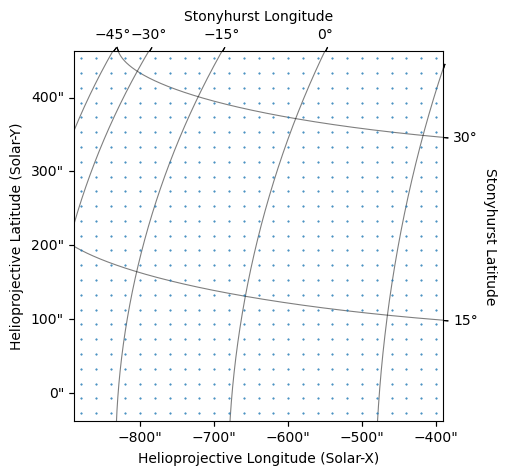

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=instrument_map)
instrument_map.plot(axes=ax, title=False)
instrument_map.draw_grid(axes=ax, color='k')
for los in lines_of_sight:
    ax.plot_coord(los[0], color='C0', marker='.', ls='', markersize=1,)
plt.show()

The next step is to define our simulation box. We'll choose somewhat arbitrary dimensions
for our box and then compute the offsets of each of the corners from the center of the box.

In [ ]:
box_dimensions = u.Quantity([100,100,200])*u.Mm
corners = list(itertools.product(box_dimensions[0]/2*[-1,1],
                                 box_dimensions[1]/2*[-1,1],
                                 box_dimensions[2]/2*[-1,1]))

We then define the edges of the box by considering all possible combinations of two corners
and keeping only those combinations who vary along a single dimension.

In [ ]:
edges = []
for possible_edges in itertools.combinations(corners,2):
    diff_edges = u.Quantity(possible_edges[0])-u.Quantity(possible_edges[1])
    if np.count_nonzero(diff_edges) == 1:
        edges.append(possible_edges)

Finally, we can define the edge coordinates of the box by first creating a coordinate to
represent the origin. This is easily computed from our point that defined the orientation
since this is the point at which the box is tangent to the solar surface.

In [ ]:
box_origin = hcc_orientation.transform_to(frame_hcc)
box_origin = SkyCoord(x=box_origin.x,
                      y=box_origin.y,
                      z=box_origin.z+box_dimensions[2]/2,
                      frame=box_origin.frame)

Using that origin, we can compute the coordinates of all edges.

In [ ]:
edge_coords = []
for edge in edges:
    edge_coords.append(SkyCoord(x=box_origin.x+u.Quantity([edge[0][0],edge[1][0]]),
                                y=box_origin.y+u.Quantity([edge[0][1],edge[1][1]]),
                                z=box_origin.z+u.Quantity([edge[0][2],edge[1][2]]),
                                frame=box_origin.frame))

Let's overlay the simulation box on top of our fake map we created earlier to see if things
look right.

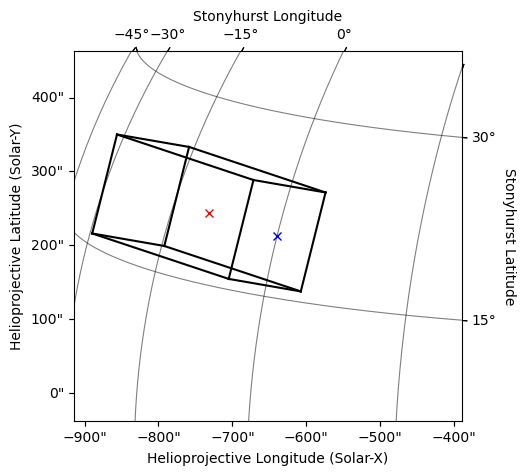

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=instrument_map)
instrument_map.plot(axes=ax, title=False)
instrument_map.draw_grid(axes=ax, color='k')
for edge in edge_coords:
    ax.plot_coord(edge, color='k', ls='-', marker='')
ax.plot_coord(box_origin, color='r', marker='x')
ax.plot_coord(hcc_orientation, color='b', marker='x')
plt.show()

Let's combine all of these pieces by plotting the lines of sight and the simulation box on
a single plot. We'll also overlay the pixel grid of our fake image.

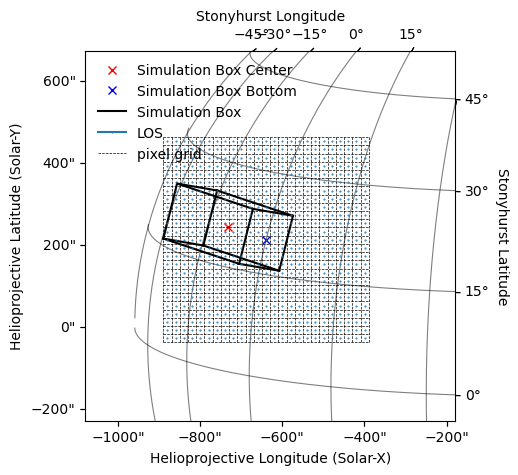

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=instrument_map)
instrument_map.plot(axes=ax, title=False)
instrument_map.draw_grid(axes=ax, color='k')
ax.plot_coord(box_origin, marker='x', color='r', ls='', label='Simulation Box Center')
ax.plot_coord(hcc_orientation, color='b', marker='x', ls='', label='Simulation Box Bottom')
for i,edge in enumerate(edge_coords):
    ax.plot_coord(edge, color='k', ls='-', label='Simulation Box' if i==0 else None)
# Plot the pixel center positions
for i,los in enumerate(lines_of_sight):
    ax.plot_coord(los[0], color='C0', marker='.', label='LOS' if i==0 else None, markersize=1)
# Plot the edges of the pixel grid
xpix_edges = np.array(range(int(instrument_map.dimensions.x.value)+1))-0.5
ypix_edges = np.array(range(int(instrument_map.dimensions.y.value)+1))-0.5
ax.vlines(x=xpix_edges,
          ymin=ypix_edges[0],
          ymax=ypix_edges[-1],
          color='k', ls='--', lw=.5, label='pixel grid')
ax.hlines(y=ypix_edges,
          xmin=xpix_edges[0],
          xmax=xpix_edges[-1],
          color='k', ls='--', lw=.5,)
ax.legend(loc=2, frameon=False)
ax.set_xlim(-10, 35)
ax.set_ylim(-10, 35)
plt.show()

Finally, we have all of the pieces of information we need to understand whether a given LOS
intersects the simulation box. First, we define a function that takes in the edge coordinates
of our box and a LOS coordinate and returns to us a boolean mask of where that LOS coordinate
falls in the box.

In [ ]:
def is_coord_in_box(box_edges, coord):
    box_edges = SkyCoord(box_edges)
    coord_hcc = coord.transform_to(box_edges.frame)
    in_x = np.logical_and(coord_hcc.x<box_edges.x.max(), coord_hcc.x>box_edges.x.min())
    in_y = np.logical_and(coord_hcc.y<box_edges.y.max(), coord_hcc.y>box_edges.y.min())
    in_z = np.logical_and(coord_hcc.z<box_edges.z.max(), coord_hcc.z>box_edges.z.min())
    return np.all([in_x, in_y, in_z], axis=0)

Next we define another map, using a different orientation from our observer, so we can look
at the intersection of the box and the many LOS from a different viewing angle.

In [ ]:
new_obs = SkyCoord(lon=25*u.deg, lat=0*u.deg, radius=1*u.AU, frame='heliographic_stonyhurst')
earth_map = make_fake_map(
    hcc_orientation.transform_to(Helioprojective(observer=new_obs, obstime=date))
)

Finally, we'll create another visualization that combines the simulation box with the lines
of sight and additional highlighting that shows *where* the LOS intersect the box.

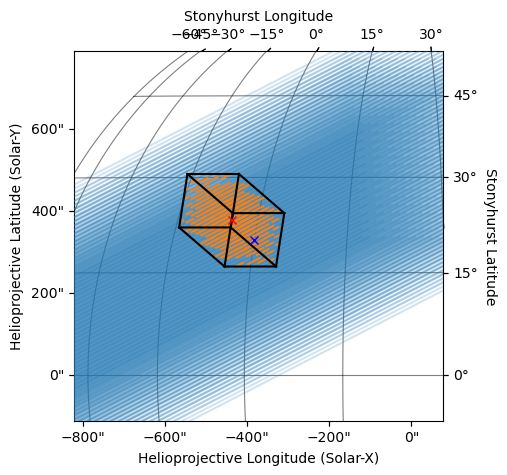

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=earth_map)
earth_map.plot(axes=ax, title=False)
earth_map.draw_grid(axes=ax, color='k')
for los in lines_of_sight:
    ax.plot_coord(los, color='C0', marker='', ls='-', alpha=0.2)
for los in lines_of_sight:
    inside_box = is_coord_in_box(edge_coords, los)
    if inside_box.any():
        ax.plot_coord(los[inside_box], color='C1', marker='', ls='-')
for edge in edge_coords:
    ax.plot_coord(edge, color='k', ls='-')
ax.plot_coord(box_origin, marker='x', color='r')
ax.plot_coord(hcc_orientation, color='b', marker='x', ls='')
ax.set_xlim(-10, 35)
ax.set_ylim(-10, 35)

plt.show()